In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1 : 시계열 데이터 준비

In [40]:
file_path = 'C:/users/juwon/practice_aiffel/stock_prediction/'
samsung = pd.read_csv(file_path+'005930.KS.csv',index_col='Date',parse_dates=True)
df =samsung.copy()
df = df['Close']
df

Date
2021-12-27    80200.0
2021-12-28    80300.0
2021-12-29    78800.0
2021-12-30    78300.0
2022-01-04    78700.0
               ...   
2022-12-19    59500.0
2022-12-20    58600.0
2022-12-21    58000.0
2022-12-22    59100.0
2022-12-23    58100.0
Name: Close, Length: 244, dtype: float64

## Step 2 : 각종 전처리 수행

In [3]:
df.interpolate(method='time')
df[df.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
df_log = np.log(df)
df_log

Date
2021-12-27    11.292279
2021-12-28    11.293525
2021-12-29    11.274668
2021-12-30    11.268303
2022-01-04    11.273398
                ...    
2022-12-19    10.993732
2022-12-20    10.978490
2022-12-21    10.968198
2022-12-22    10.986986
2022-12-23    10.969921
Name: Close, Length: 244, dtype: float64

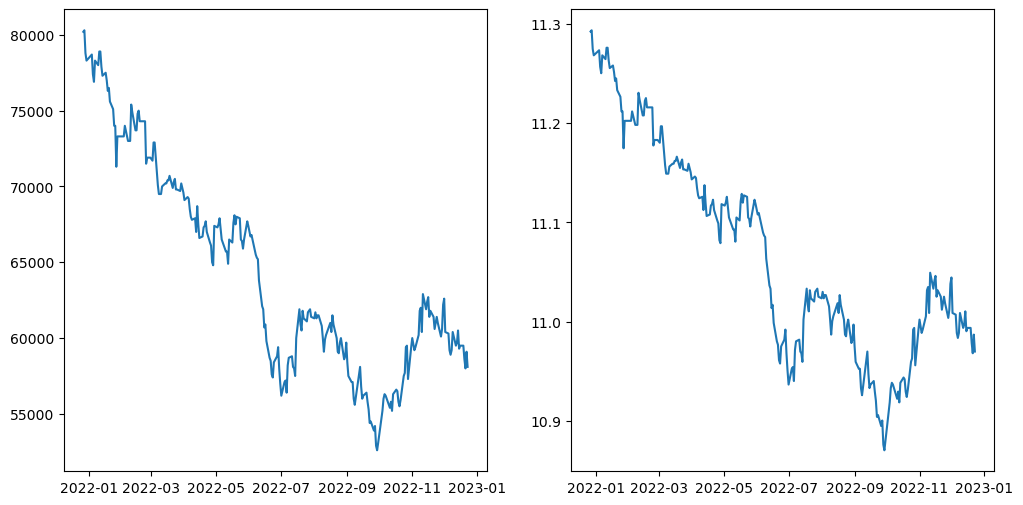

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(df)
plt.subplot(122)
plt.plot(df_log)

## Step 3 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller-Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

### 3-1. 정성적 그래프 분석

In [6]:
def plot_rolling_statistics(timeseries,window=12):
    rollmean = timeseries.rolling(window=window).mean()
    rollstd = timeseries.rolling(window=window).std()
    
    plt.plot(timeseries,label='origin')
    plt.plot(rollmean,c='r',label='mean')
    plt.plot(rollstd,c='b',label='std')
    plt.legend()
    plt.show(block=False)

### 3-2. 정량적 분석

In [7]:
def augmented_dicky_fuller_test(timeseries) :
    result = adfuller(timeseries, autolag='AIC')
    
    resultout = pd.Series(result[0:4],index=['Test statistic','p-value','#Lag used','Number of observation used'])
    for key, value in result[4].items() :
        resultout['Critical Value (%s)' % key] = value
    print(resultout)

#### 1.로그를 취한 데이터

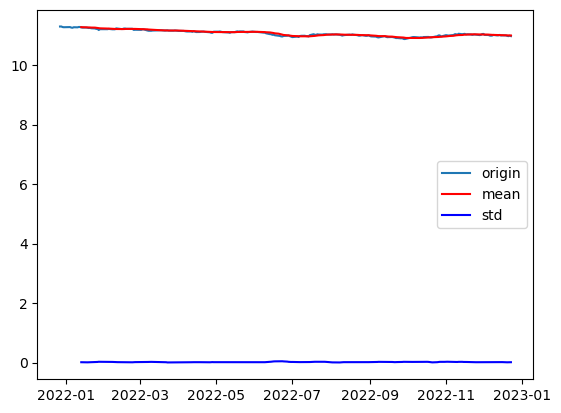

Test statistic                 -1.899106
p-value                         0.332482
#Lag used                       2.000000
Number of observation used    241.000000
Critical Value (1%)            -3.457779
Critical Value (5%)            -2.873609
Critical Value (10%)           -2.573202
dtype: float64


In [8]:
plot_rolling_statistics(df_log,window=12)
augmented_dicky_fuller_test(df_log)

#### 2.원본 데이터

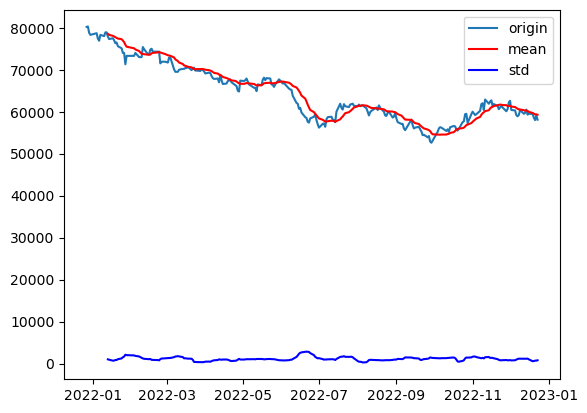

Test statistic                 -2.090305
p-value                         0.248431
#Lag used                       2.000000
Number of observation used    241.000000
Critical Value (1%)            -3.457779
Critical Value (5%)            -2.873609
Critical Value (10%)           -2.573202
dtype: float64


In [9]:
plot_rolling_statistics(df,window=12)
augmented_dicky_fuller_test(df)

## 3-3. 시계열 분해

* 추세
    * 장기적으로 증가하거나,감소하는 경향성이 존재하는 것을 의미
    * 주로 시계열에서 기울기가 증가하거나 감소할 때 관찰됨.
    * 일정시간 발생했다가 사라지고 반복되지 않음.
* 계절성
    * 계절적 요인의 영향을 받아 1년, 혹은 일정 기간 안에 반복적으로 나타나는 패턴
    * 빈도의 형태로 나타나며 항상 일정한 경우가 많음.
* 주기성
    * 정해지지 않은 빈도, 기간으로 일어나는 상승 혹은 하락을 의미함. 학자마다 정의가 다름.

추세는 이동평균으로 계산, 계절성은 1차차분으로 계산

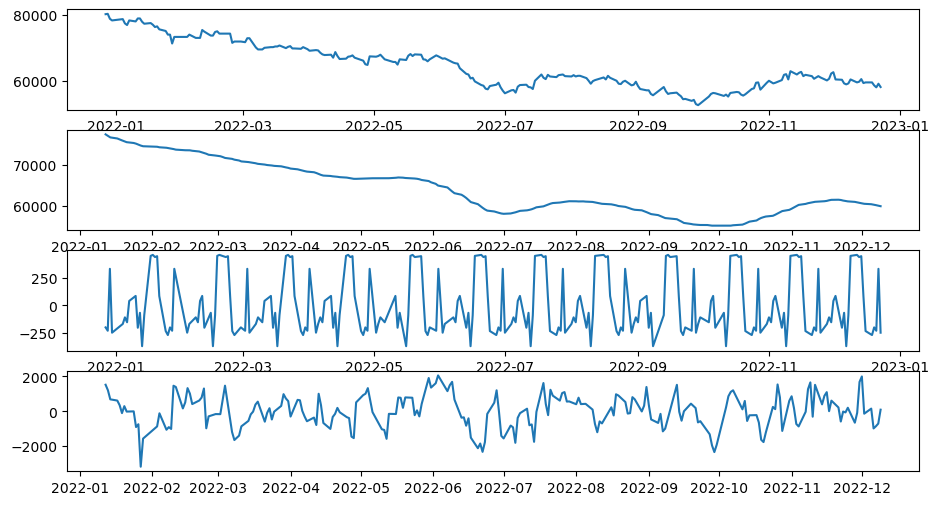

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, model='applicative', period = 20) 
    
trend = decomposition.trend  # 추세
seasonal = decomposition.seasonal # 계절성
residual = decomposition.resid # 원본 - 추세 - 계절성
    
plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(df,label='origin')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.subplot(414)
plt.plot(residual, label='residual')
plt.show()

* ~주식시장은 월-금만 운영되므로 주기를 한달로 잡고 period=20 으로 설정~

## 3-4. residual 안정성 확인

In [22]:
residual.dropna(inplace=True)
augmented_dicky_fuller_test(residual)

Test statistic               -7.518075e+00
p-value                       3.855574e-11
#Lag used                     1.000000e+00
Number of observation used    2.220000e+02
Critical Value (1%)          -3.460154e+00
Critical Value (5%)          -2.874649e+00
Critical Value (10%)         -2.573757e+00
dtype: float64


## Step 4 : 학습, 테스트 셋 생성

(219,)
(25,)


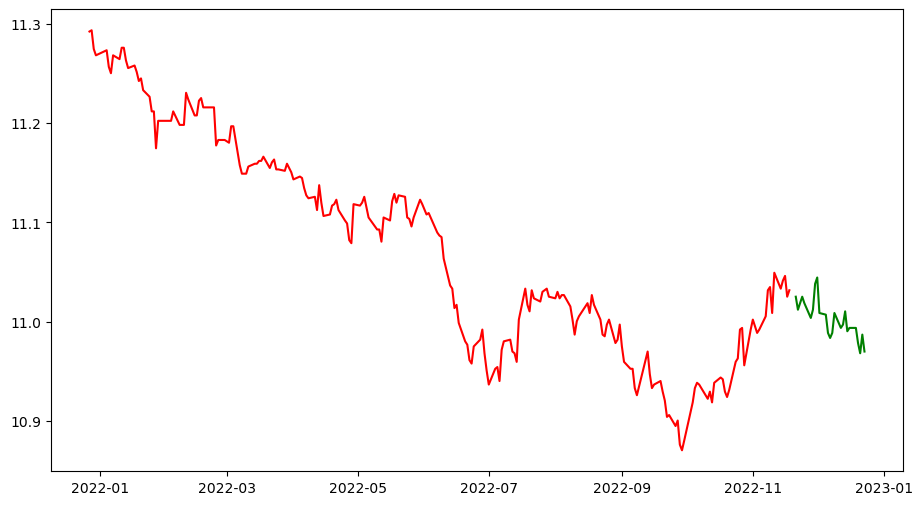

In [12]:
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
print(train_data.shape)
print(test_data.shape)
plt.plot(train_data,c='r')
plt.plot(test_data,c='g')
plt.show()

## STEP 5 : 적정 ARIMA 모수 찾기

### 5-1. ACF, PACF 그려보기 > p, q 찾기

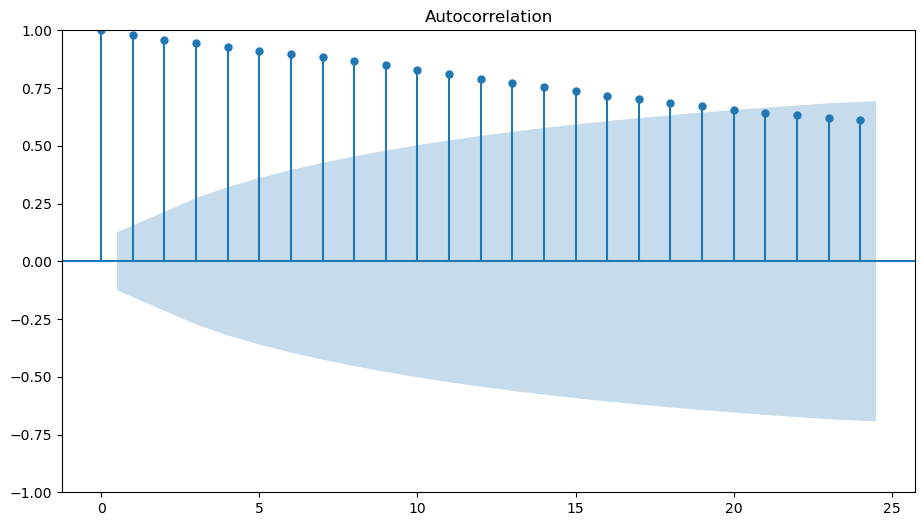

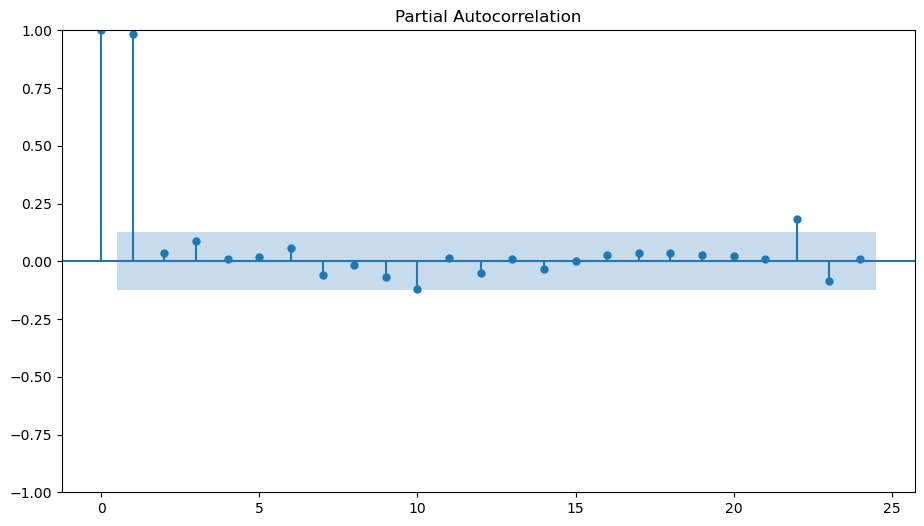

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_log)
plot_pacf(df_log)
plt.show()

* ACF에서 점차

### 5-2. 차분 안정성 확인 > d 구하기

#### 1차 차분 구하기

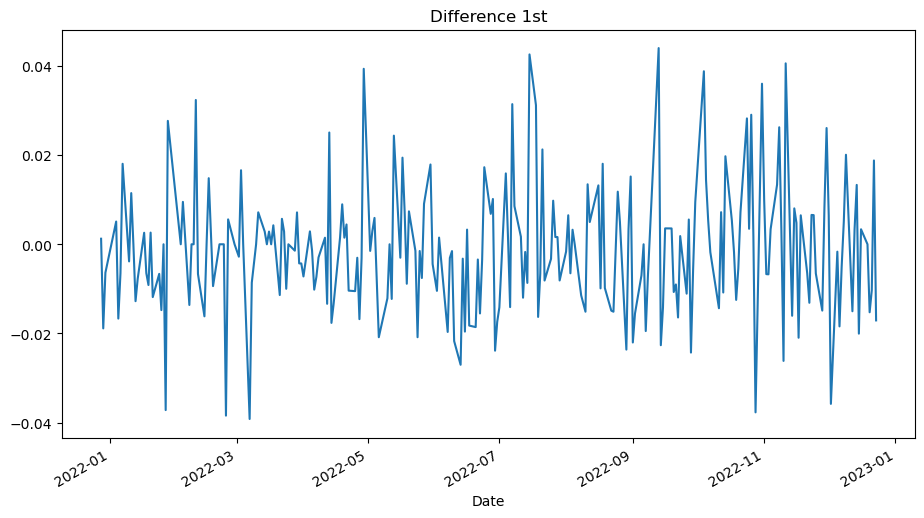

Test statistic               -1.296236e+01
p-value                       3.205579e-24
#Lag used                     1.000000e+00
Number of observation used    2.410000e+02
Critical Value (1%)          -3.457779e+00
Critical Value (5%)          -2.873609e+00
Critical Value (10%)         -2.573202e+00
dtype: float64


In [14]:
diff_1 = df_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
plt.show()

augmented_dicky_fuller_test(diff_1)

#### 2차 차분구하기

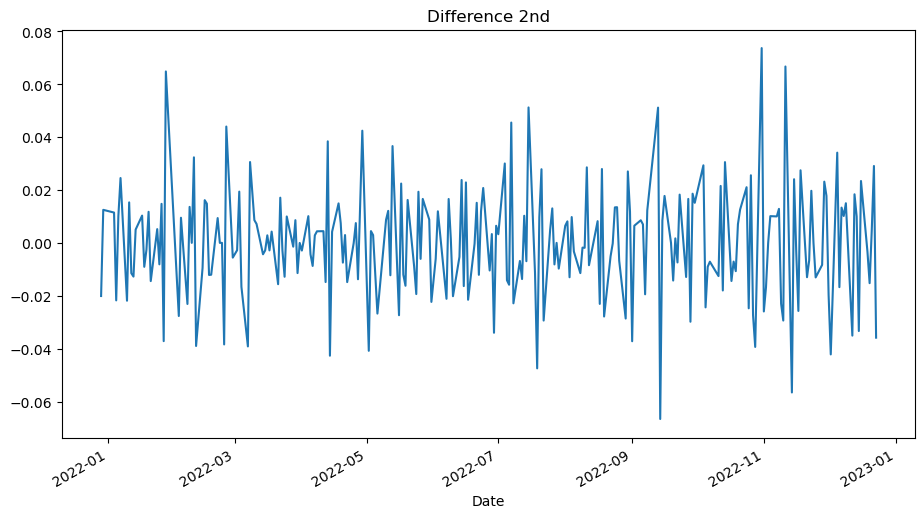

Test statistic               -8.992471e+00
p-value                       6.832969e-15
#Lag used                     9.000000e+00
Number of observation used    2.320000e+02
Critical Value (1%)          -3.458855e+00
Critical Value (5%)          -2.874080e+00
Critical Value (10%)         -2.573453e+00
dtype: float64


In [15]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title = 'Difference 2nd')
plt.show()
augmented_dicky_fuller_test(diff_2)

#### 3차 차분 구하기

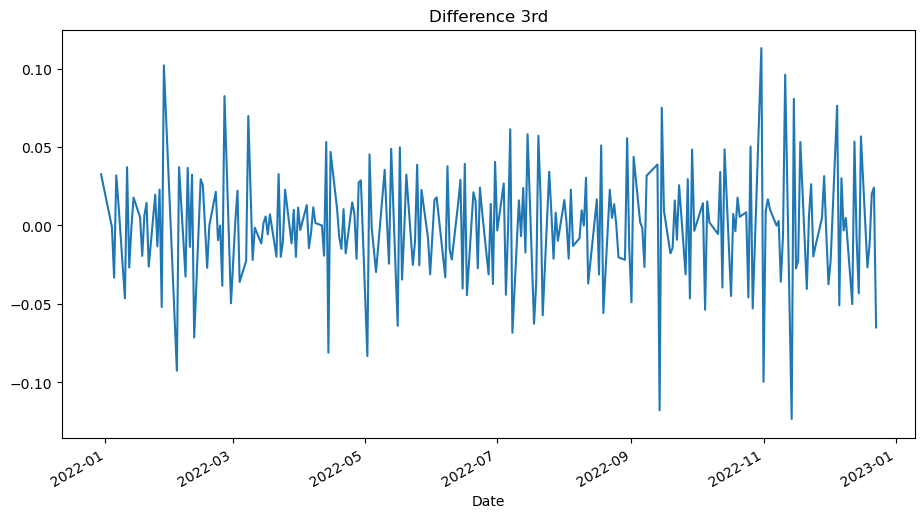

Test statistic               -8.789925e+00
p-value                       2.255015e-14
#Lag used                     1.500000e+01
Number of observation used    2.250000e+02
Critical Value (1%)          -3.459752e+00
Critical Value (5%)          -2.874473e+00
Critical Value (10%)         -2.573663e+00
dtype: float64


In [16]:
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')
plt.show()
augmented_dicky_fuller_test(diff_3)

* 1차(d=1) 차분에서 가장 낮은 p-value 값을 얻었으므로, 가장 안정성이 있다고 볼 수 있다. 따라서 d=1로 시도하겠다.

## Step 6 : ARIMA 모델 훈련과 테스트

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order =(22,1,0))
fitted_m = model.fit()

print(fitted_m.summary())

C:\Users\juwon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\juwon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\juwon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  219
Model:                ARIMA(22, 1, 0)   Log Likelihood                 623.575
Date:                Mon, 26 Dec 2022   AIC                          -1201.150
Time:                        18:36:10   BIC                          -1123.307
Sample:                             0   HQIC                         -1169.708
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0637      0.072     -0.885      0.376      -0.205       0.077
ar.L2         -0.1244      0.080     -1.557      0.119      -0.281       0.032
ar.L3         -0.0072      0.086     -0.083      0.9

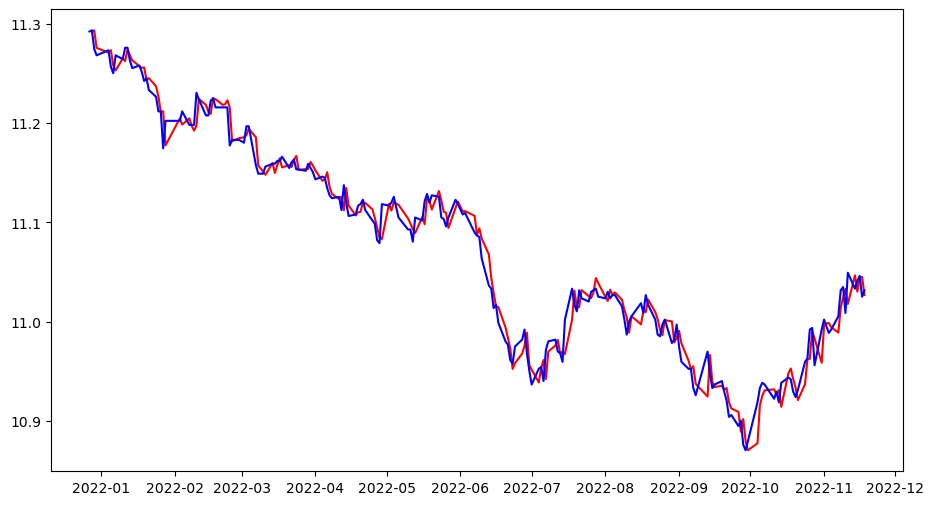

In [26]:
fitted_m = fitted_m.predict()
fitted_m=fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m,c='r')
plt.plot(train_data,c='b')
plt.show()

C:\Users\juwon\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


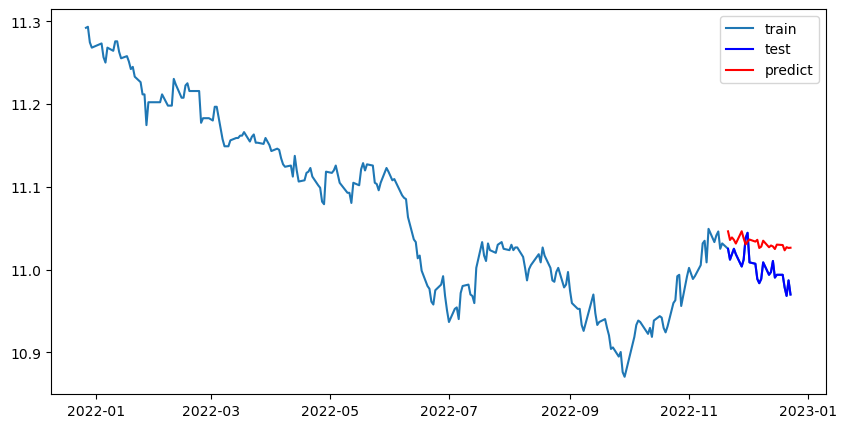

In [28]:
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

fc_series = pd.Series(fc,index=test_data.index)

plt.figure(figsize=(10,5))
plt.plot(df_log,label ='train')
plt.plot(test_data,c='b',label='test')
plt.plot(fc_series,c='r',label='predict')
plt.legend()
plt.show()

In [35]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/ np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4182430.3944174782
MAE:  1879.5988714312239
RMSE:  2045.099116037528
MAPE: 3.16%


In [36]:
np.exp(fc)

array([62709.1979704 , 62057.5575561 , 62249.84044776, 62071.53912143,
       61790.74898496, 62716.36655782, 62184.0651475 , 61724.17704895,
       61948.98885277, 62091.15394492, 61936.05217184, 62070.34140866,
       61461.0732183 , 61558.21545936, 62004.32813119, 61515.25011147,
       61646.3219389 , 61575.37512385, 61383.4941656 , 61711.6069651 ,
       61680.20498109, 61288.20750089, 61519.50209341, 61463.65765587,
       61479.03703109])

In [37]:
np.exp(test_data)

Date
2022-11-21    61400.0
2022-11-22    60600.0
2022-11-23    61000.0
2022-11-24    61400.0
2022-11-25    61000.0
2022-11-28    60100.0
2022-11-29    60600.0
2022-11-30    62200.0
2022-12-01    62600.0
2022-12-02    60400.0
2022-12-05    60300.0
2022-12-06    59200.0
2022-12-07    58900.0
2022-12-08    59200.0
2022-12-09    60400.0
2022-12-12    59500.0
2022-12-13    59700.0
2022-12-14    60500.0
2022-12-15    59300.0
2022-12-16    59500.0
2022-12-19    59500.0
2022-12-20    58600.0
2022-12-21    58000.0
2022-12-22    59100.0
2022-12-23    58100.0
Name: Close, dtype: float64

# 쿠팡(NYSE), 위니아(KQ,071460), 피씨엘(KQ,241820) 예측해보기

## 1. 쿠팡

## Step 1 : 데이터 준비

In [157]:
cpng = pd.read_csv(file_path+'CPNG.csv', index_col='Date', parse_dates=True).copy()
winia = pd.read_csv(file_path + 'winia.csv', index_col='일자', parse_dates=True, encoding='cp949').copy()
pcl = pd.read_csv(file_path+ 'pcl.csv',index_col='일자', parse_dates=True, encoding='cp949').copy()

cpng = cpng['Close']
winia = winia['종가'].astype('float')
pcl = pcl['종가'].astype('float')
cpng.head(3)

Date
2021-12-23    30.23
2021-12-27    29.42
2021-12-28    29.52
Name: Close, dtype: float64

In [158]:
winia.head(3)

일자
2021-12-24    3770.0
2021-12-27    3815.0
2021-12-28    3760.0
Name: 종가, dtype: float64

In [159]:
pcl.head(3)

일자
2021-12-24    35800.0
2021-12-27    34950.0
2021-12-28    34000.0
Name: 종가, dtype: float64

## Step 2 : 각종 전처리 수행

In [160]:
cpng[cpng.isna()]

Series([], Name: Close, dtype: float64)

In [161]:
winia[winia.isna()]

Series([], Name: 종가, dtype: float64)

In [162]:
pcl[pcl.isna()]

Series([], Name: 종가, dtype: float64)

## Step 3 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller-Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

### 3-1. 정성적 그래프 분석

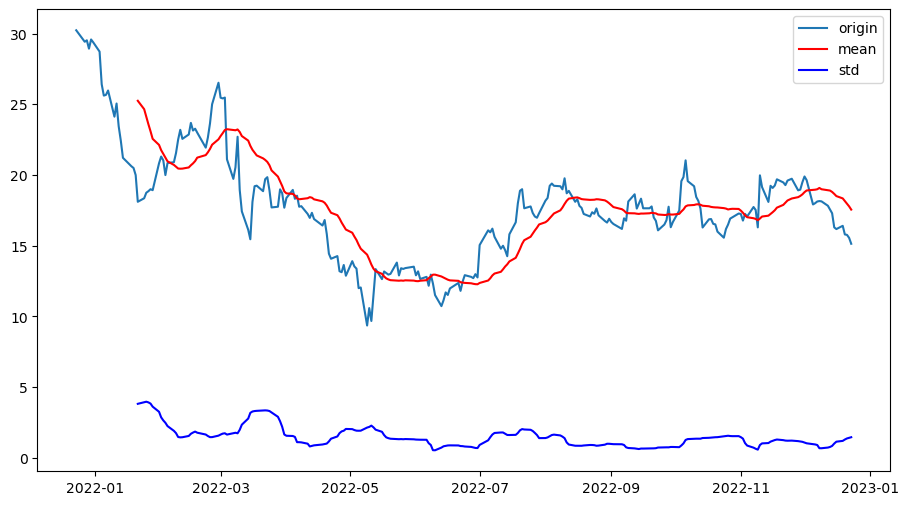

In [163]:
plot_rolling_statistics(cpng,window=20)

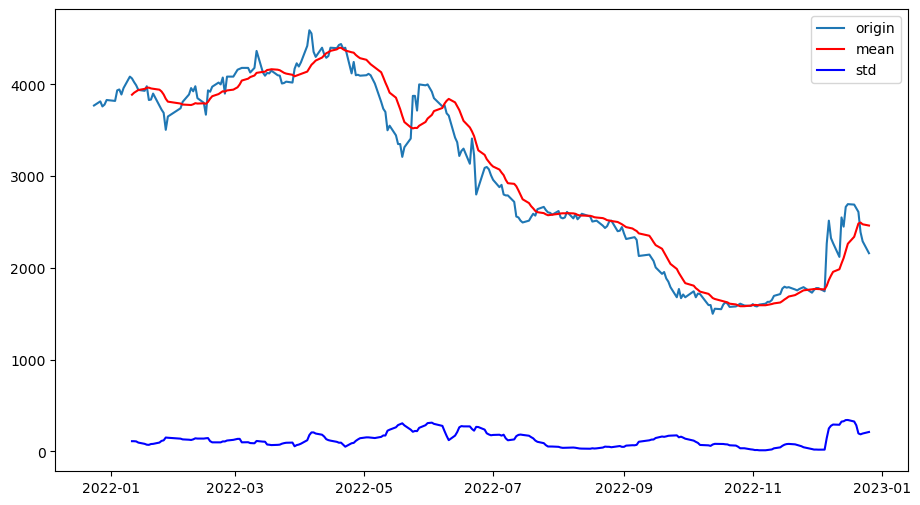

In [164]:
plot_rolling_statistics(winia)

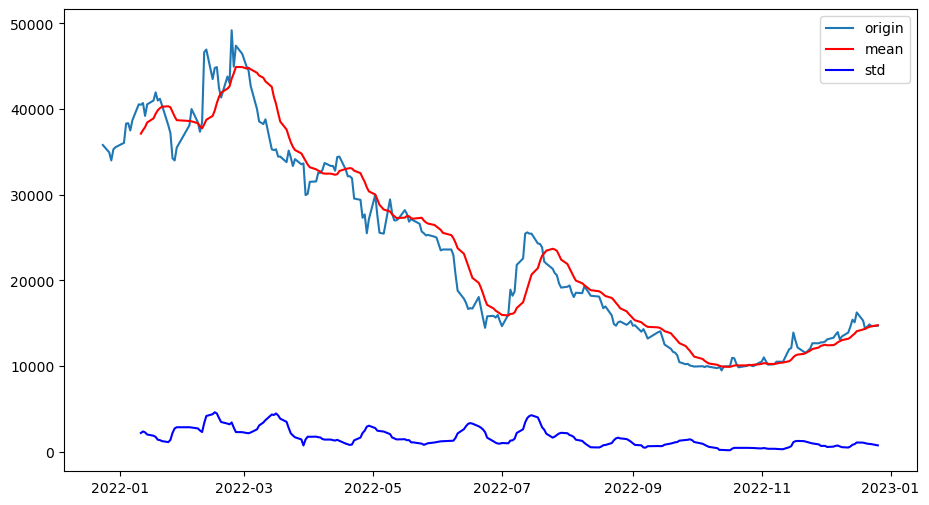

In [165]:
plot_rolling_statistics(pcl)

### 3-2. 정량적 분석

In [166]:
augmented_dicky_fuller_test(cpng)

Test statistic                 -3.247950
p-value                         0.017372
#Lag used                       0.000000
Number of observation used    252.000000
Critical Value (1%)            -3.456569
Critical Value (5%)            -2.873079
Critical Value (10%)           -2.572919
dtype: float64


* cpng의 시계열이 안정적이지 않다는 귀무가설은 0.017로 유의미한 값이므로, 귀무가설을 기각하고 대립가설을 채택.

In [167]:
augmented_dicky_fuller_test(winia)

Test statistic                 -0.787095
p-value                         0.822883
#Lag used                       0.000000
Number of observation used    247.000000
Critical Value (1%)            -3.457105
Critical Value (5%)            -2.873314
Critical Value (10%)           -2.573044
dtype: float64


In [168]:
winia_log = np.log(winia)
augmented_dicky_fuller_test(winia_log)

Test statistic                 -0.828716
p-value                         0.810541
#Lag used                       0.000000
Number of observation used    247.000000
Critical Value (1%)            -3.457105
Critical Value (5%)            -2.873314
Critical Value (10%)           -2.573044
dtype: float64


* winia의 시계열이 안정적이지 않다는 귀무가설은 p-value가 높게 나왔으므로, 귀무가설을 기각할 순 없지만, 안정적 시계열은 아니다.
* 로그변환을 해도 차이가 없으므로 원본 데이터를 쓴다.

In [169]:
augmented_dicky_fuller_test(pcl)

Test statistic                 -1.061662
p-value                         0.730116
#Lag used                       0.000000
Number of observation used    247.000000
Critical Value (1%)            -3.457105
Critical Value (5%)            -2.873314
Critical Value (10%)           -2.573044
dtype: float64


In [170]:
pcl_log=np.log(pcl)
augmented_dicky_fuller_test(pcl_log)

Test statistic                 -0.969571
p-value                         0.764200
#Lag used                       0.000000
Number of observation used    247.000000
Critical Value (1%)            -3.457105
Critical Value (5%)            -2.873314
Critical Value (10%)           -2.573044
dtype: float64


* pcl의 시계열이 안정적이지 않다는 귀무가설은 p-value가 높게 나왔으므로, 귀무가설을 기각할 순 없지만, 안정적 시계열은 아니다.
* 로그변환을 해도 차이가 없으므로 원본 데이터를 쓴다.

### 3-3. 시계열 분해

In [171]:
def decomposition(timeseries) :
    decomposition = seasonal_decompose(timeseries, model='applicative', period = 20) 
    
    trend = decomposition.trend  # 추세
    seasonal = decomposition.seasonal # 계절성
    residual = decomposition.resid # 원본 - 추세 - 계절성
    
    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(timeseries,label='origin')
    plt.subplot(412)
    plt.plot(trend,label='trend')
    plt.subplot(413)
    plt.plot(seasonal, label='seasonal')
    plt.subplot(414)
    plt.plot(residual, label='residual')
    residual.dropna(inplace=True)
    augmented_dicky_fuller_test(residual) #residual의 그래프의 안정성 검정
    plt.show()

#### cpng

Test statistic               -7.043922e+00
p-value                       5.751813e-10
#Lag used                     4.000000e+00
Number of observation used    2.280000e+02
Critical Value (1%)          -3.459361e+00
Critical Value (5%)          -2.874302e+00
Critical Value (10%)         -2.573571e+00
dtype: float64


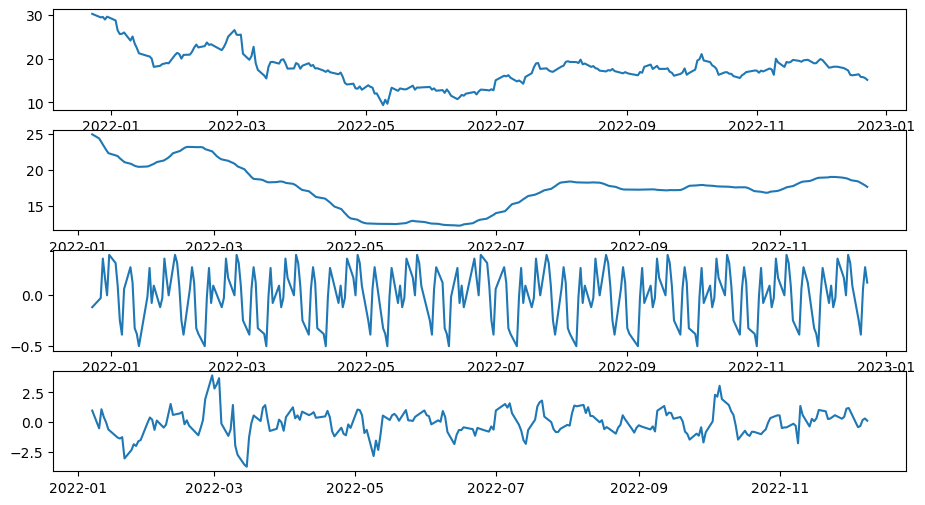

In [172]:
decomposition(cpng)

#### winia

Test statistic               -6.603898e+00
p-value                       6.630362e-09
#Lag used                     1.000000e+00
Number of observation used    2.260000e+02
Critical Value (1%)          -3.459620e+00
Critical Value (5%)          -2.874415e+00
Critical Value (10%)         -2.573632e+00
dtype: float64


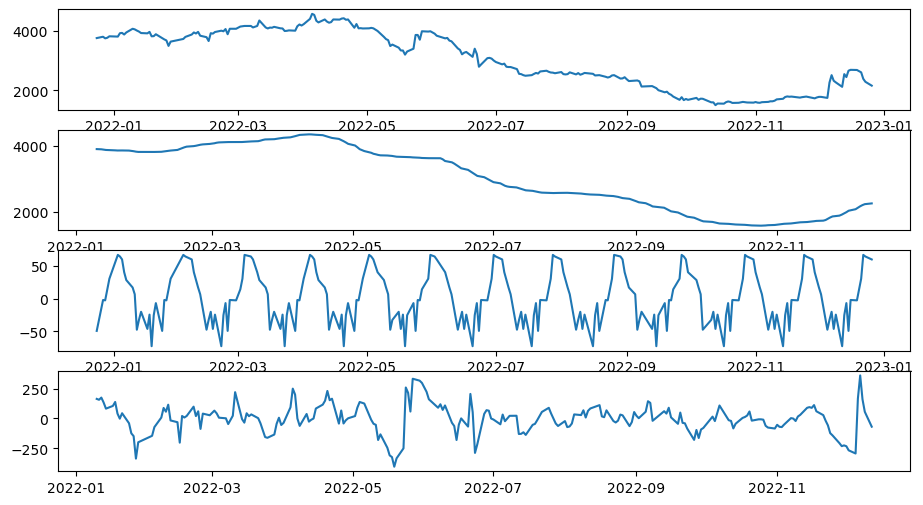

In [173]:
decomposition(winia)

#### pcl

Test statistic               -6.603898e+00
p-value                       6.630362e-09
#Lag used                     1.000000e+00
Number of observation used    2.260000e+02
Critical Value (1%)          -3.459620e+00
Critical Value (5%)          -2.874415e+00
Critical Value (10%)         -2.573632e+00
dtype: float64


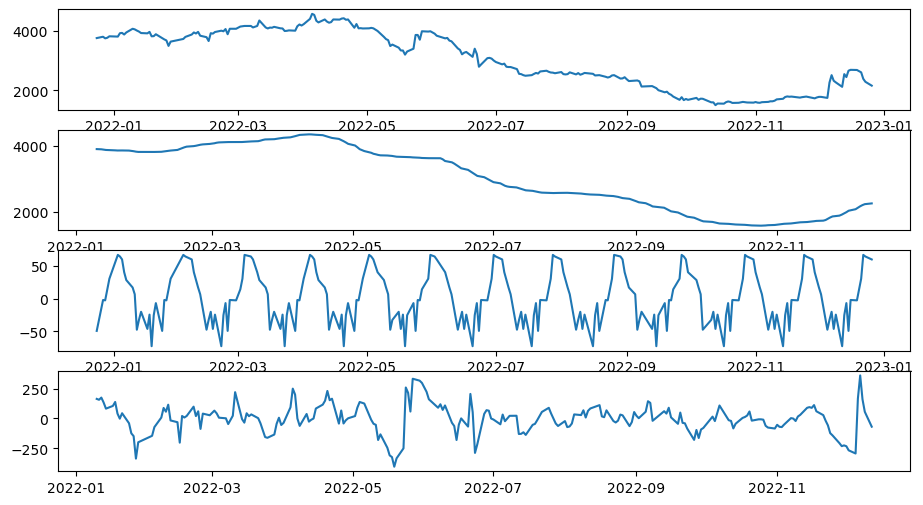

In [174]:
decomposition(winia)

### 3-4. residual 안정성 확인

* 위에서 seasonal_decompose와 residual의 안정성 검정을 하였다. 3개의 데이터 p-value가 충분히 낮게 나왔으므로,
안정적이지 않다는 귀무가설을 기각하고 대립가설을 채택.

## Step 4 : 학습, 테스트 셋 생성

### 4-1. cpng

(227,)
(26,)


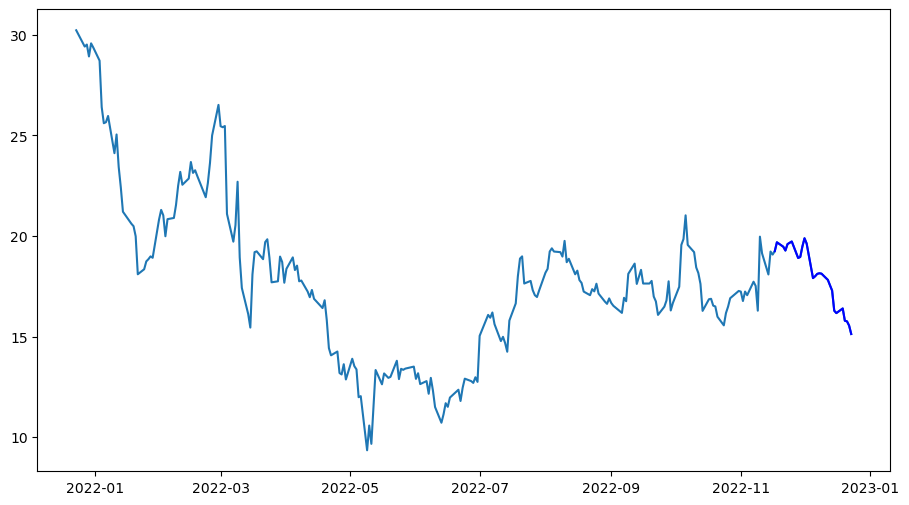

In [175]:
cpng_train_data, cpng_test_data = cpng[:int(len(cpng)*0.9)], cpng[int(len(cpng)*0.9):]
print(cpng_train_data.shape)
print(cpng_test_data.shape)

plt.plot(cpng, label='origin')
plt.plot(cpng_test_data,c='b', label = 'test')
plt.show()

### 4-2. winia 

(223,)
(25,)


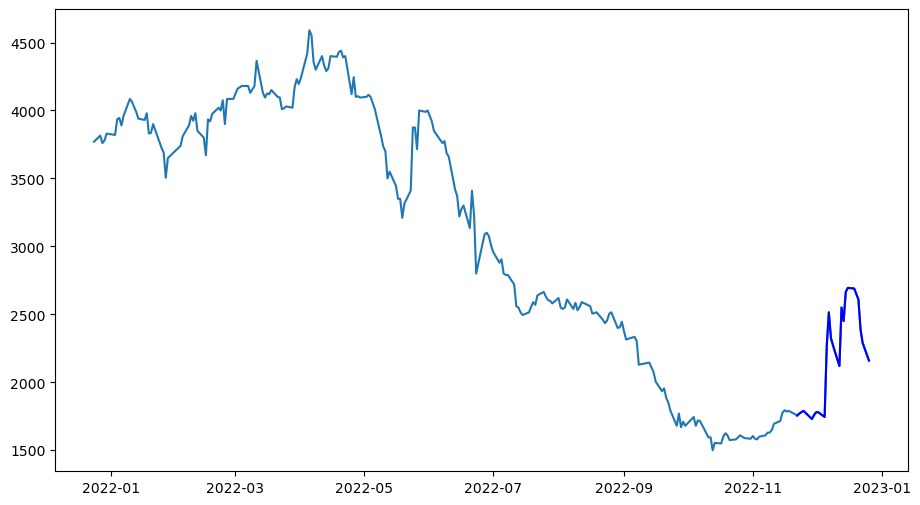

In [176]:
winia_train_data, winia_test_data = winia[:int(len(winia)*0.9)], winia[int(len(winia)*0.9):]
print(winia_train_data.shape)
print(winia_test_data.shape)

plt.plot(winia, label='origin')
plt.plot(winia_test_data,c='b', label = 'test')
plt.show()

### 4-3. pcl 

(223,)
(25,)


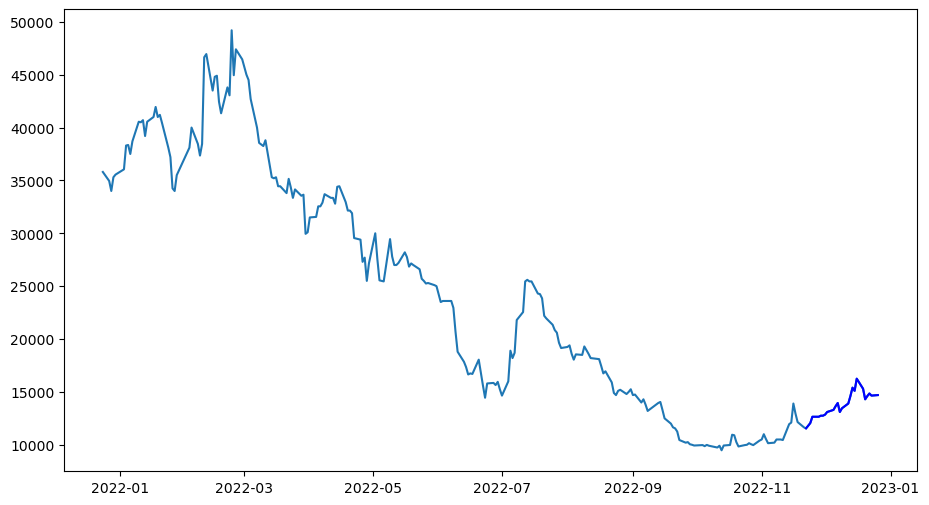

In [177]:
pcl_train_data, pcl_test_data = pcl[:int(len(winia)*0.9)], pcl[int(len(winia)*0.9):]
print(pcl_train_data.shape)
print(pcl_test_data.shape)

plt.plot(pcl, label='origin')
plt.plot(pcl_test_data,c='b', label = 'test')
plt.show()

## Step 5 : 적정 ARIMA 모수 찾기

### 5-1-1. cpng p,q 찾기

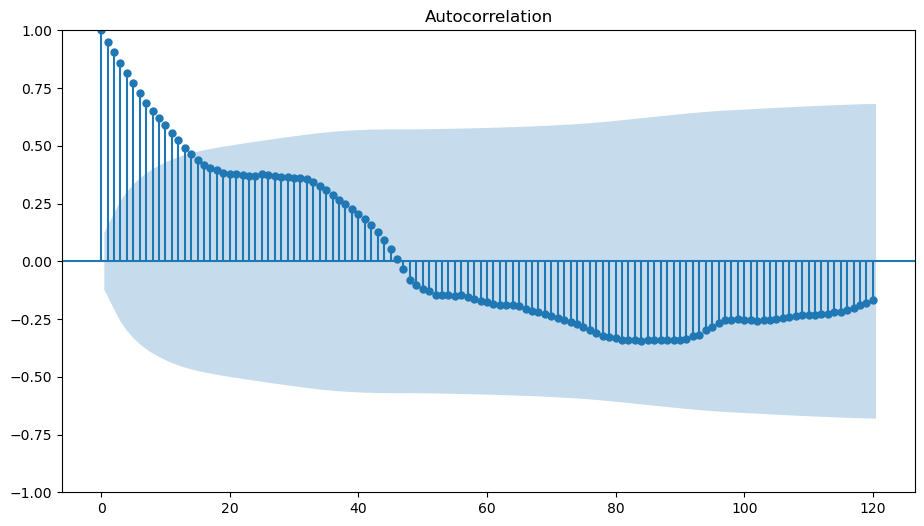

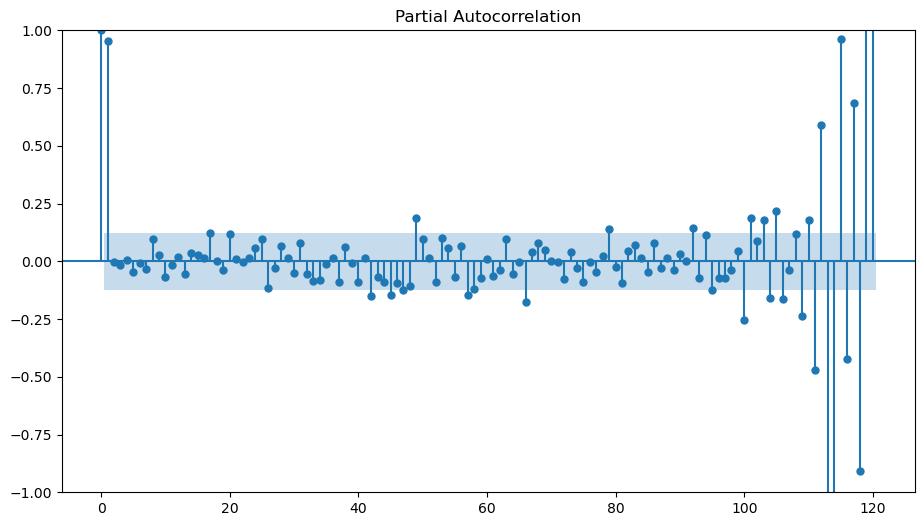

In [279]:
plot_acf(cpng,lags=120)
plot_pacf(cpng,lags=120)
plt.show()

* 절단점을 찾기어려워 lag을 늘렸지만 역시 어렵다.
* 시게열 뿐인 단변량 데이터와 많은 외부적 요인의 개입들로 적절한 값을 찾지 못했다. auto_arima를 통해 최적의 값을 찾겠다.

In [352]:
import pmdarima as pm
model_cpng = pm.auto_arima(y = cpng,
                           d=1,
                           start_p=0,
                           max_p=120,
                           start_q=0,
                           max_q=120,
                           seasonal=False,
                           stepwise=False,
                           trace= True
                          )

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=662.491, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=664.444, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=666.334, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=668.257, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=670.256, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=671.978, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=664.446, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=666.416, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=668.253, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=671.991, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=666.330, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=668.215, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=670.243, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept

* order = (0, 1, 0)으로 설정.

### 5-1-2. d 찾기

Test statistic               -1.558720e+01
p-value                       1.899974e-28
#Lag used                     0.000000e+00
Number of observation used    2.510000e+02
Critical Value (1%)          -3.456674e+00
Critical Value (5%)          -2.873125e+00
Critical Value (10%)         -2.572944e+00
dtype: float64

Test statistic               -6.292532e+00
p-value                       3.570250e-08
#Lag used                     1.600000e+01
Number of observation used    2.340000e+02
Critical Value (1%)          -3.458608e+00
Critical Value (5%)          -2.873972e+00
Critical Value (10%)         -2.573396e+00
dtype: float64


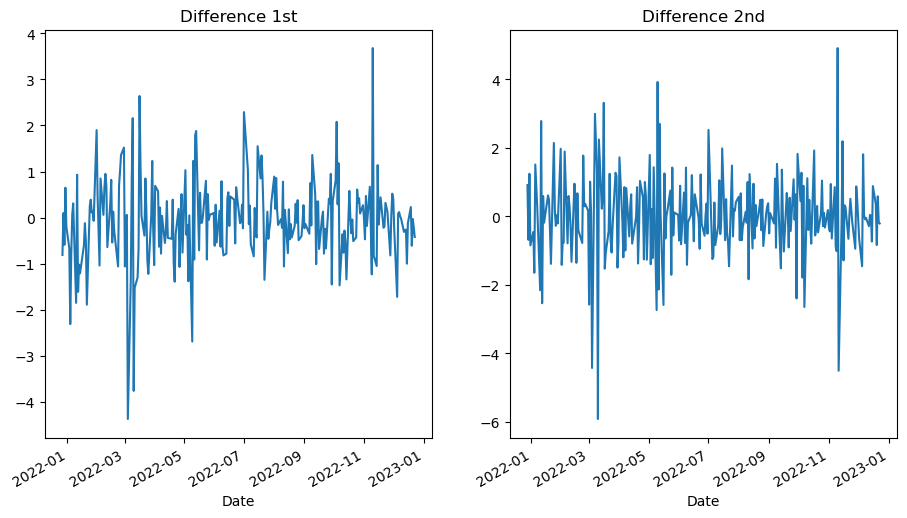

In [324]:
cpng_diff_1 = cpng.diff(periods=1).iloc[1:]
cpng_diff_2 = cpng_diff_1.diff(periods=1).iloc[1:]
augmented_dicky_fuller_test(cpng_diff_1)
print("")
augmented_dicky_fuller_test(cpng_diff_2)
plt.subplot(121)
cpng_diff_1.plot(title='Difference 1st')
plt.subplot(122)
cpng_diff_2.plot(title='Difference 2nd')
plt.show()

* 1차 차분이 더 안정적이므로 d=1로 시도할 것.

### 5-2-1. winia p,q 찾기

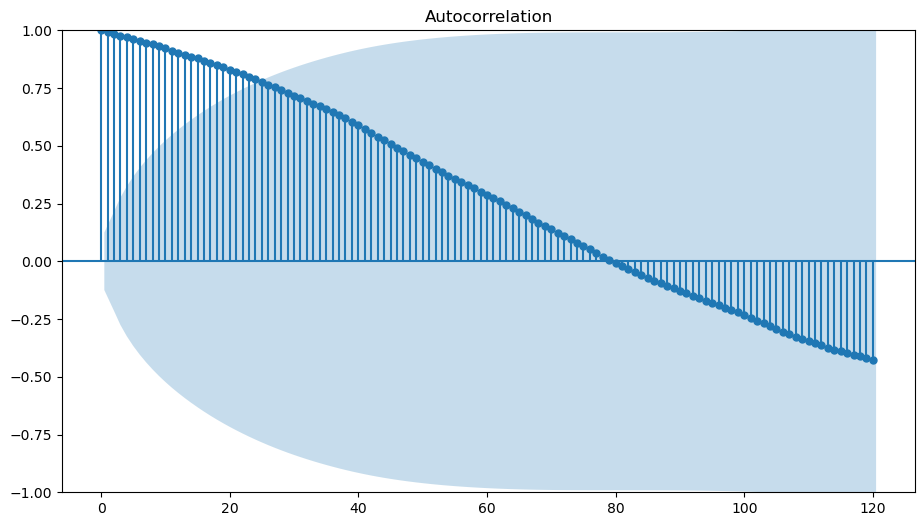

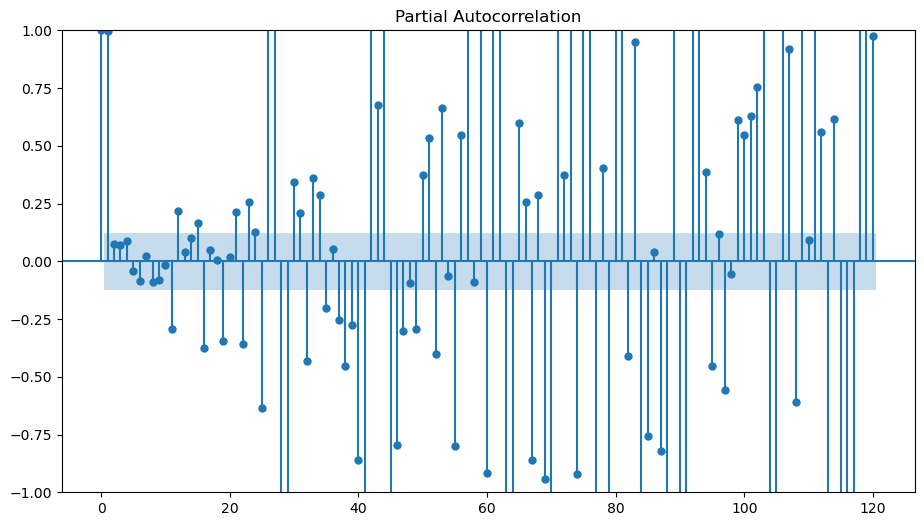

In [325]:
plot_acf(winia,lags=120)
plot_pacf(winia,lags=120)
plt.show()

* ### cpng와 마찬가지로 적절한 절단점을 찾기 어렵다. auto_arima로 모수를 설정하겠다.

In [359]:
model_winia = pm.auto_arima(y = winia,
                            d=1,
                           start_p=0,
                           max_p=120,
                            start_q=0,
                            max_q = 120,
                            seasonal=True,
                            stepwise=False,
                            trace= True
                           )

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=3001.897, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=3003.515, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=3005.472, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=3007.462, Time=0.10 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=3008.911, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=3009.537, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=3003.528, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=3005.489, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=3007.471, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=3009.472, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=3010.349, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=3005.466, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=3007.485, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)

* ### winia는 계절에 영향을 받는 주이므로, seasonal = True로 설정하였다. order = (0,1,0)

### 5-2-2 d 찾기

Test statistic               -1.621556e+01
p-value                       3.945900e-29
#Lag used                     0.000000e+00
Number of observation used    2.460000e+02
Critical Value (1%)          -3.457215e+00
Critical Value (5%)          -2.873362e+00
Critical Value (10%)         -2.573070e+00
dtype: float64

Test statistic               -6.649456e+00
p-value                       5.164940e-09
#Lag used                     1.600000e+01
Number of observation used    2.290000e+02
Critical Value (1%)          -3.459233e+00
Critical Value (5%)          -2.874245e+00
Critical Value (10%)         -2.573541e+00
dtype: float64


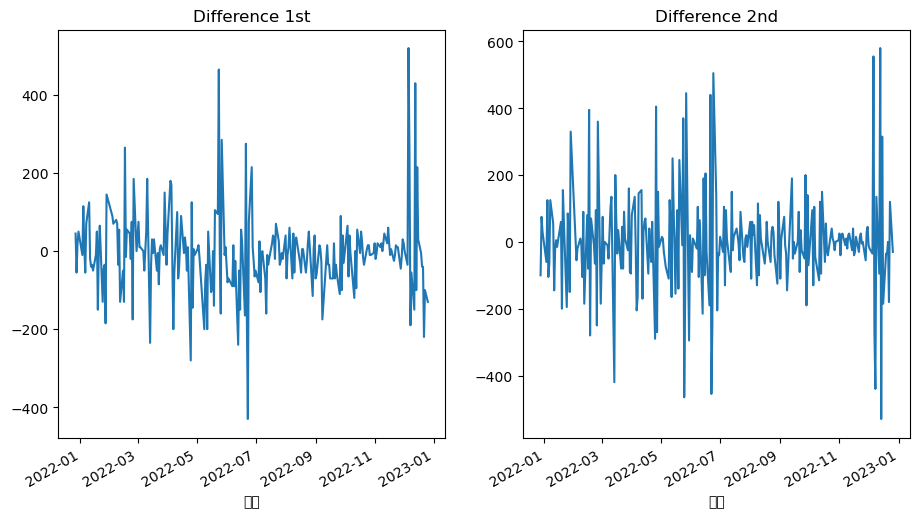

In [372]:
winia_diff_1 = winia.diff(periods=1).iloc[1:]
winia_diff_2 = winia_diff_1.diff(periods=1).iloc[1:]
augmented_dicky_fuller_test(winia_diff_1)
print("")
augmented_dicky_fuller_test(winia_diff_2)
plt.subplot(121)
winia_diff_1.plot(title='Difference 1st')
plt.subplot(122)
winia_diff_2.plot(title='Difference 2nd')
plt.show()

* 1차 차분이 더 안정적이므로 d=1로 시도할 것.

### 5-3-1. pcl p,q 찾기

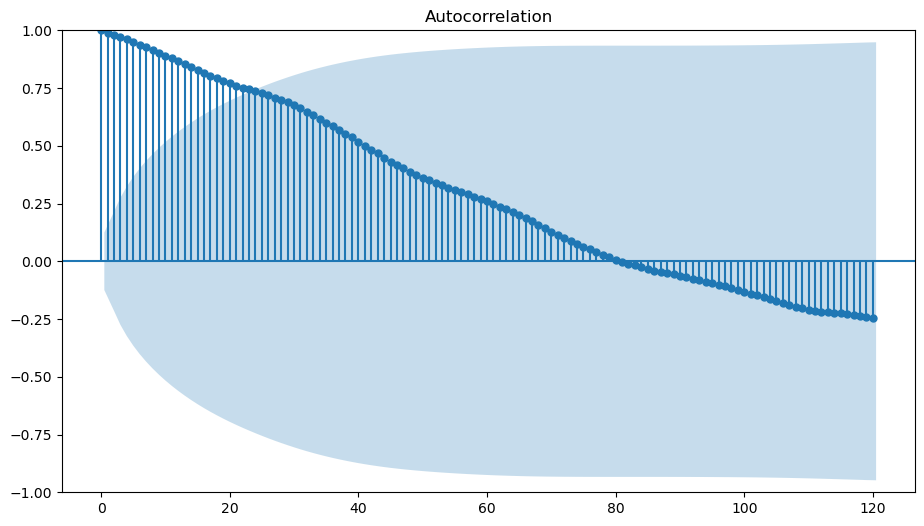

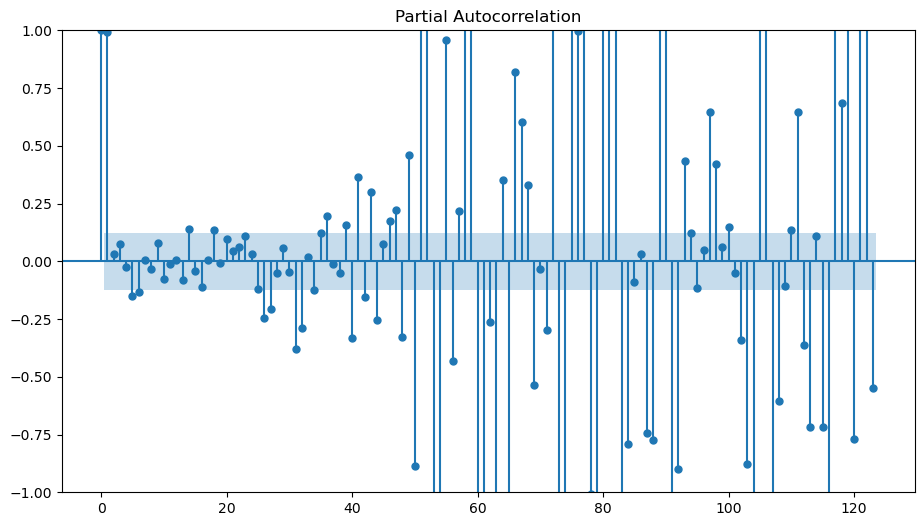

In [258]:
plot_acf(pcl,lags=120)
plot_pacf(pcl,lags=123)
plt.show()

In [365]:
model_pcl = pm.auto_arima(y = pcl,
              d=1,
              start_p=0,
              max_p=120,
              start_q=0,
              max_q=120,
              seasonal=False,
              stepwise=False,
              trace= True
             )

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4242.063, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4243.643, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4244.924, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4246.438, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4245.799, Time=0.04 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4245.983, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4243.669, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4245.564, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4246.682, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4247.913, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4247.138, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4244.652, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4246.594, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4235.287, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4247.233, Time=0.18 sec
 ARIMA(3,1

* ### order = (2, 1, 2)

### 5-3-2. d 찾기

Test statistic               -1.591287e+01
p-value                       8.086145e-29
#Lag used                     0.000000e+00
Number of observation used    2.460000e+02
Critical Value (1%)          -3.457215e+00
Critical Value (5%)          -2.873362e+00
Critical Value (10%)         -2.573070e+00
dtype: float64

Test statistic               -7.271836e+00
p-value                       1.580999e-10
#Lag used                     1.300000e+01
Number of observation used    2.320000e+02
Critical Value (1%)          -3.458855e+00
Critical Value (5%)          -2.874080e+00
Critical Value (10%)         -2.573453e+00
dtype: float64


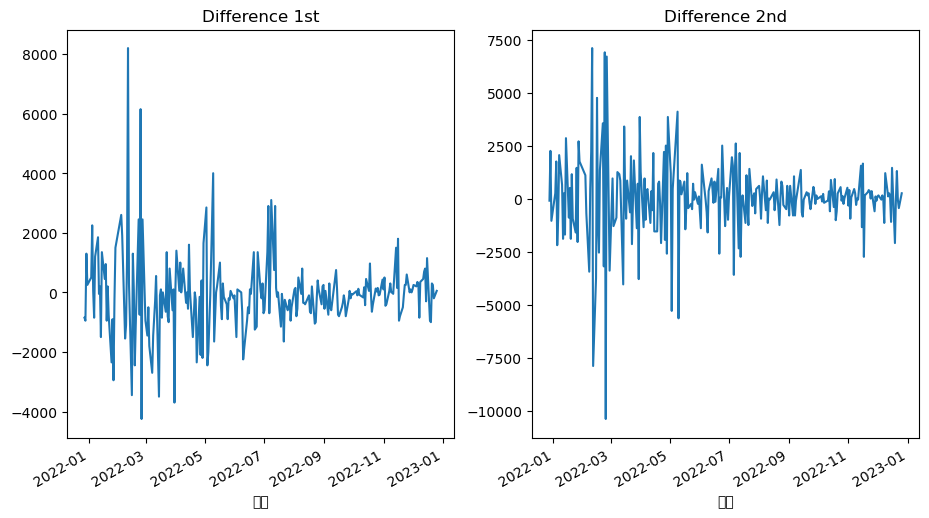

In [183]:
pcl_diff_1 = pcl.diff(periods=1).iloc[1:]
pcl_diff_2 = pcl_diff_1.diff(periods=1).iloc[1:]
augmented_dicky_fuller_test(pcl_diff_1)
print("")
augmented_dicky_fuller_test(pcl_diff_2)
plt.subplot(121)
pcl_diff_1.plot(title='Difference 1st')
plt.subplot(122)
pcl_diff_2.plot(title='Difference 2nd')
plt.show()

* 1차 차분이 더 안정적이므로 d=1로 시도할 것.

## Step 6 : ARIMA 모델 훈련과 테스트

### 6-1. cpng

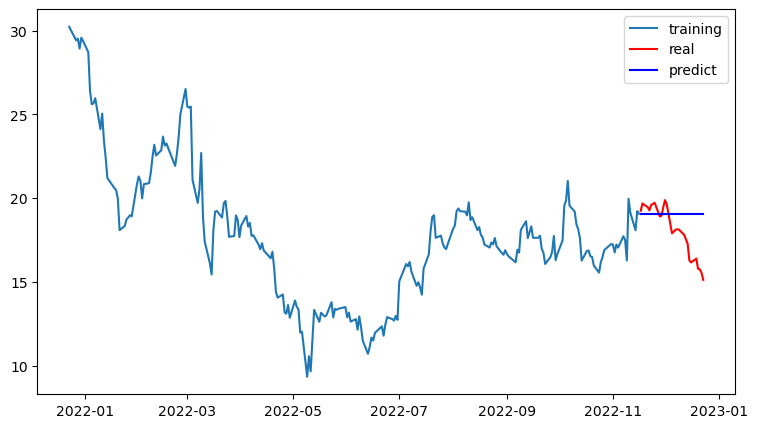

In [368]:
model_cpng = ARIMA(cpng_train_data, order=(0,1,0))
fitted_cpng = model_cpng.fit()
fc_cpng = fitted_cpng.forecast(len(cpng_test_data),alpha=0.05)  
fc_cpng = np.array(fc_cpng)
fc_cpng_series = pd.Series(fc_cpng, index=cpng_test_data.index) 

plt.figure(figsize=(9,5),dpi=100)
plt.plot(cpng_train_data,label='training')
plt.plot(cpng_test_data,c='r',label = 'real')
plt.plot(fc_cpng_series,c='b',label='predict')
plt.legend()
plt.show()

### 6-2. winia

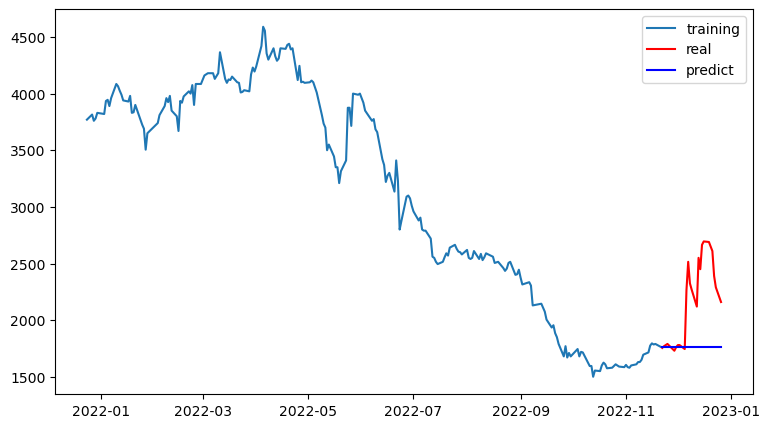

In [369]:
model_winia = ARIMA(winia_train_data, order=(0,1,0))
fitted_winia = model_winia.fit()
fc_winia = fitted_winia.forecast(len(winia_test_data),alpha=0.05)  
fc_winia = np.array(fc_winia)
fc_winia_series = pd.Series(fc_winia, index=winia_test_data.index) 

plt.figure(figsize=(9,5),dpi=100)
plt.plot(winia_train_data,label='training')
plt.plot(winia_test_data,c='r',label = 'real')
plt.plot(fc_winia_series,c='b',label='predict')
plt.legend()
plt.show()

### 6-3. pcl

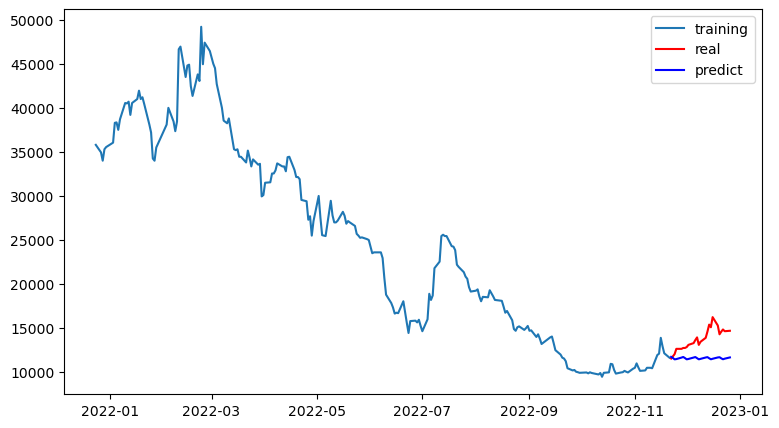

In [355]:
model_pcl = ARIMA(pcl_train_data, order=(2,1,2))
fitted_pcl = model_pcl.fit()
fc_pcl = fitted_pcl.forecast(len(pcl_test_data),alpha=0.05)  
fc_pcl = np.array(fc_pcl)
fc_pcl_series = pd.Series(fc_pcl, index=pcl_test_data.index) 

plt.figure(figsize=(9,5),dpi=100)
plt.plot(pcl_train_data,label='training')
plt.plot(pcl_test_data,c='r',label = 'real')
plt.plot(fc_pcl_series,c='b',label='predict')
plt.legend()
plt.show()

## Step 7. 데이터 지수 변환

### 7-1. cpng

In [366]:
mse_cpng = mean_squared_error(cpng_test_data,fc_cpng)
print(mse_cpng)
mae_cpng = mean_absolute_error(cpng_test_data,fc_cpng)
print(mae)
rmse_cpng = mse_cpng ** 0.5
print(rmse_cpng)
mape_cpng = np.mean(np.abs(fc_cpng - cpng_test_data)/np.abs(cpng_test_data))
print(round(mape_cpng*100,3),'%')

3.390357393846573
1879.5988714312239
1.8412923162405725
8.459 %


### 7-2. winia

In [370]:
mse_winia = mean_squared_error(winia_test_data,fc_winia)
print(mse_winia)
mae_winia = mean_absolute_error(winia_test_data,fc_winia)
print(mae_winia)
rmse_winia= mse_winia ** 0.5
print(rmse)
mape_winia = np.mean(np.abs(fc_winia-winia_test_data)/np.abs(winia_test_data))
print(round(mape_winia*100,3),'%')

297845.0
413.4
2045.099116037528
16.756 %


### 7-3. pcl

In [358]:
mse_pcl = mean_squared_error(pcl_test_data, fc_pcl)
print(mse)
mae_pcl = mean_absolute_error(pcl_test_data, fc_pcl)
print(mae)
rmse_pcl = mse ** 0.5
print(rmse)
mape_pcl = np.mean(np.abs(fc_pcl - pcl_test_data) / np.abs(pcl_test_data))
print(round(mape_pcl*100,3),'%')

4182430.3944174782
1879.5988714312239
2045.099116037528
15.061 %


## 결론

* 주식 정보를 시계열과 종가만으로 예측하기에는 외부요인의 영향이 많이 큰 것 같다.
* acf, pacf 그래프로 적당한 절단점을 찾지 못하여 auto_arima를 사용했다. auto_arima를 통한 p,d,q를 적용했을 때
mape 값이 낮게 나올 줄 알았는데 값도 높게나오고 그래프도 마지막 값에서 변하지 않는 모습을 보여준다.
* 아마도, 불규칙한 데이터들의 규칙성을 찾지 못해서 합리적으로 예측값을 마지막 출력값으로 한 것 같다.